In [1]:
import os
import glob
import pandas as pd

In [2]:
dir_path = 'data/delays/concatenated_delays'
file_pattern = '*_delays.csv'

search_pattern = os.path.join(dir_path, file_pattern)
delay_files = glob.glob(search_pattern)

delay_list_df = []
for file in delay_files:
    temp_df = pd.read_csv(file)
    temp_df['Origin Airport'] = os.path.basename(file)[:3]
    delay_list_df.append(temp_df)

if delay_list_df:
    delay_df = pd.concat(delay_list_df, ignore_index=True)
    print(f'Successfully combined {len(delay_list_df)} files.')
else:
    print(f'Errored out.')

Successfully combined 33 files.


In [3]:
delay_df['Date (MM/DD/YYYY)'] = pd.to_datetime(delay_df['Date (MM/DD/YYYY)'])
delay_df['Scheduled departure time'].replace(to_replace='24:00', value='00:00', inplace=True)
delay_df['Scheduled departure time'] = pd.to_datetime(delay_df['Scheduled departure time'], format='%H:%M')
delay_df[['Date (MM/DD/YYYY)', 'Departure delay (Minutes)', 'Scheduled departure time']].describe()

,Date (MM/DD/YYYY),Departure delay (Minutes),Scheduled departure time
count,22083346,2.208335e+07,22083346
mean,2023-06-22 14:51:26.118201344,1.229128e+01,1900-01-01 13:58:52.980430336
min,2021-01-01 00:00:00,-1.050000e+02,1900-01-01 00:00:00
25%,2022-04-28 00:00:00,-5.000000e+00,1900-01-01 09:45:00
50%,2023-07-05 00:00:00,-1.000000e+00,1900-01-01 13:50:00
75%,2024-08-21 00:00:00,9.000000e+00,1900-01-01 18:10:00
max,2025-09-30 00:00:00,7.223000e+03,1900-01-01 23:59:00
std,NaN,5.020648e+01,NaN


In [4]:
delay_df.drop([delay_df.columns[0]], axis=1, inplace=True)

In [5]:
dup_cols = ['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Scheduled departure time', 'Origin Airport']
print(f'Before dropping duplicates: {len(delay_df)} rows.')
delay_df.drop_duplicates(inplace=True)
print(f'After dropping duplicates: {len(delay_df)} rows.')

Before dropping duplicates: 22083346 rows.
After dropping duplicates: 21052708 rows.


In [6]:
print(f'Before dropping > 24 hour delays: {len(delay_df)} rows.')
delay_df = delay_df[delay_df['Departure delay (Minutes)'] < 24*60]
print(f'After dropping > 24 hour delays: {len(delay_df)} rows.')

Before dropping > 24 hour delays: 21052708 rows.
After dropping > 24 hour delays: 21051951 rows.


In [7]:
import numpy as np

delay_df['Delayed'] = np.where(delay_df['Departure delay (Minutes)'] > 0, 1, 0)

In [8]:
delay_df['DayOfYear'] = delay_df['Date (MM/DD/YYYY)'].dt.dayofyear
delay_df['Hour'] = delay_df['Scheduled departure time'].dt.hour + delay_df['Scheduled departure time'].dt.minute / 60

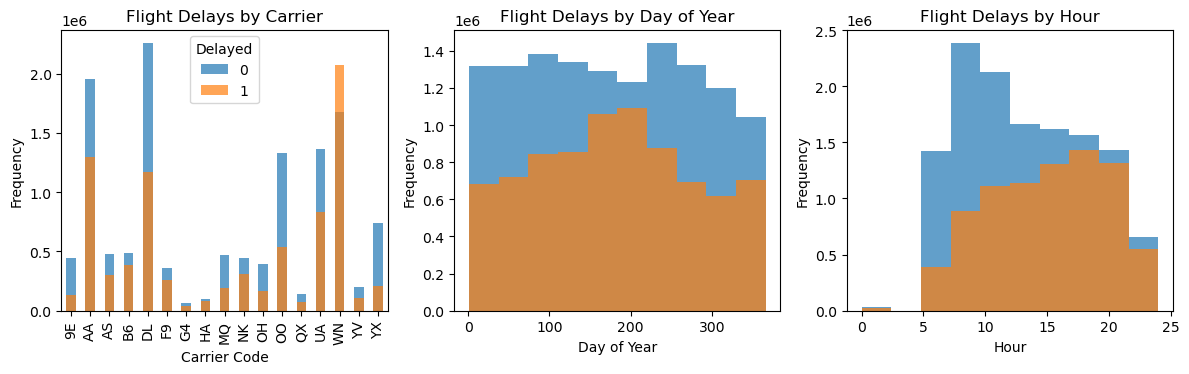

In [10]:
import matplotlib.pyplot as plt

delay_df['DayOfYear'] = delay_df['Date (MM/DD/YYYY)'].dt.dayofyear
delay_df['Hour'] = delay_df['Scheduled departure time'].dt.hour + delay_df['Scheduled departure time'].dt.minute / 60

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
delay_df.groupby(['Carrier Code', 'Delayed']).size().unstack(fill_value=0)[0].plot(
    kind='bar', 
    stacked=True,
    alpha=0.7,
    legend=True,
    title='Flight Delays by Carrier',
    label='0',
    ax=axs[0],
    color='tab:blue'
)
delay_df.groupby(['Carrier Code', 'Delayed']).size().unstack(fill_value=0)[1].plot(
    kind='bar', 
    stacked=True,
    alpha=0.7,
    legend=True,
    label='1',
    ax=axs[0],
    color='tab:orange'
)
axs[0].set_xlabel('Carrier Code')
axs[0].set_ylabel('Frequency')
axs[0].legend(title='Delayed')

delay_df.groupby('Delayed')['DayOfYear'].plot(
    kind='hist',
    stacked=True,
    alpha=0.7,
    bins=10,  # Adjust the number of bins as needed
    # legend=True,
    title='Flight Delays by Day of Year',
    ax=axs[1]
)
axs[1].set_xlabel('Day of Year')
axs[1].set_ylabel('Frequency')

delay_df.groupby('Delayed')['Hour'].plot(
    kind='hist',
    stacked=True,
    alpha=0.7,
    bins=10,  # Adjust the number of bins as needed
    # legend=True,
    title='Flight Delays by Hour',
    ax=axs[2]
)
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../../../Downloads/Delays_by_Carrier_DayOfYear_Hour_All_Airports.png')

In [9]:
delay_df = delay_df[['Origin Airport', 'Carrier Code', 'DayOfYear', 'Hour', 'Destination Airport', 'Tail Number', 'Delayed', 'Date (MM/DD/YYYY)']]
delay_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21051951 entries, 0 to 22083345
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Origin Airport       object        
 1   Carrier Code         object        
 2   DayOfYear            int32         
 3   Hour                 float64       
 4   Destination Airport  object        
 5   Tail Number          object        
 6   Delayed              int64         
 7   Date (MM/DD/YYYY)    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 1.3+ GB


In [10]:
delay_df.isna().sum()

Origin Airport             0
Carrier Code               0
DayOfYear                  0
Hour                       0
Destination Airport        0
Tail Number            56830
Delayed                    0
Date (MM/DD/YYYY)          0
dtype: int64

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupedModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        self.group_cols = group_cols
        self.target_col = target_col
        self.impute_map_ = None
        self.global_mode_ = None

    def fit(self, X, y=None):
        # Calculate mode for each group. Use 'Unknown' if there is no mode
        self.impute_map_ = X.groupby(self.group_cols)[self.target_col].apply(
            lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
        ).to_dict()
        self.n_features_in_ = X.shape[1]
        
        return self

    def transform(self, X):
        check_is_fitted(self)
        
        # Create a key for mapping groups and then fill na values
        group_keys = X[self.group_cols].apply(tuple, axis=1)        
        mask = X[self.target_col].isna()        
        X.loc[mask, self.target_col] = group_keys[mask].map(self.impute_map_)

        assert self.n_features_in_ == X.shape[1]
        return X

    def get_feature_names_out(self, input_features=None):
        # Define how feature names are transformed
        out = [f'{col}' for col in self.group_cols]
        out.append(f'{self.target_col}')
        return out

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

impute_tail = GroupedModeImputer(group_cols=['Origin Airport', 'Carrier Code', 'Destination Airport'], target_col='Tail Number')

cat_pipeline = Pipeline([
    ('fill_tail', impute_tail),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.validation import check_array, check_is_fitted

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# sine and cosine transformer classes to be used for date and time variables
class SinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.sin(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_sin' for col in input_features]

class CosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.cos(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_cos' for col in input_features]

In [14]:
from sklearn.compose import ColumnTransformer

cat_cols = ['Origin Airport', 'Carrier Code', 'Destination Airport', 'Tail Number']
date_cols = ['DayOfYear']
time_cols = ['Hour']
feature_transformer = ColumnTransformer(
    transformers=[
        ('categorical', cat_pipeline, cat_cols),
        ('day_sin', SinTransformer(365), date_cols),
        ('day_cos', CosTransformer(365), date_cols),
        ('hour_sin', SinTransformer(24), time_cols),
        ('hour_cos', CosTransformer(24), time_cols),
    ]
)

In [15]:
cutoff_date = delay_df['Date (MM/DD/YYYY)'].max() - pd.offsets.DateOffset(years=1)
train = delay_df[delay_df['Date (MM/DD/YYYY)'] < cutoff_date]
test = delay_df[delay_df['Date (MM/DD/YYYY)'] >= cutoff_date]

X_train = train.drop(['Delayed', 'Date (MM/DD/YYYY)'], axis=1)
y_train = train['Delayed']
X_test = test.drop(['Delayed', 'Date (MM/DD/YYYY)'], axis=1)
y_test = test['Delayed']

print(f'Proportion of data in training is {len(X_train) / (len(X_train) + len(X_test))}.')

Proportion of data in training is 0.7737543185427327.


In [16]:
float64_cols = list(X_train.select_dtypes(include=['float64']))
X_train[float64_cols] = X_train[float64_cols].astype('float32')

int64_cols = list(X_train.select_dtypes(include=['int64']))
X_train[int64_cols] = X_train[int64_cols].astype('int32')

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import TruncatedSVD

rnd_forest_pipeline = Pipeline([
        ('data_transformer', feature_transformer),
        # ('svd', TruncatedSVD(n_components=20)),
        ('rnd_forest_clf', RandomForestClassifier(criterion='gini', 
                                                  n_jobs=-1,
                                                  n_estimators=300,
                                                  max_depth=25, 
                                                  min_samples_split=31, 
                                                  min_samples_leaf=42,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=179,
                                                  class_weight='balanced'))
    ])

rnd_forest_pipeline.fit(X_train, y_train.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('data_transformer', ...), ('rnd_forest_clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('categorical', ...), ('day_sin', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of

In [18]:
forest_pred = rnd_forest_pipeline.predict(X_test)
forest_results = {'Accuracy': accuracy_score(y_test, forest_pred),
               'Precision': precision_score(y_test, forest_pred),
               'Recall': recall_score(y_test, forest_pred),
               'F1': f1_score(y_test, forest_pred)}
print(forest_results)
print("\nFinal Classification Report:")
print(classification_report(y_test, forest_pred, zero_division=0))

{'Accuracy': 0.6150635126024767, 'Precision': 0.49212751952906697, 'Recall': 0.5498428172128472, 'F1': 0.519386727671991}

Final Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68   2961189
           1       0.49      0.55      0.52   1801724

    accuracy                           0.62   4762913
   macro avg       0.60      0.60      0.60   4762913
weighted avg       0.62      0.62      0.62   4762913



In [19]:
feature_names = rnd_forest_pipeline.named_steps['data_transformer'].get_feature_names_out(input_features=X_train.columns)
rnd_forest_importances = rnd_forest_pipeline.named_steps['rnd_forest_clf'].feature_importances_
feature_importances_series = pd.Series(rnd_forest_importances, index=feature_names).sort_values(ascending=False)

print(feature_importances_series[:15])

categorical__Carrier Code_WN       0.173835
hour_sin__Hour_sin                 0.154836
hour_cos__Hour_cos                 0.080597
categorical__Carrier Code_YX       0.065290
day_cos__DayOfYear_cos             0.056311
categorical__Carrier Code_OO       0.056187
categorical__Carrier Code_9E       0.042832
categorical__Origin Airport_DEN    0.032088
day_sin__DayOfYear_sin             0.024887
categorical__Origin Airport_BWI    0.022998
categorical__Carrier Code_DL       0.021266
categorical__Origin Airport_MDW    0.018364
categorical__Carrier Code_OH       0.014343
categorical__Carrier Code_MQ       0.012985
categorical__Origin Airport_LAS    0.011021
dtype: float64


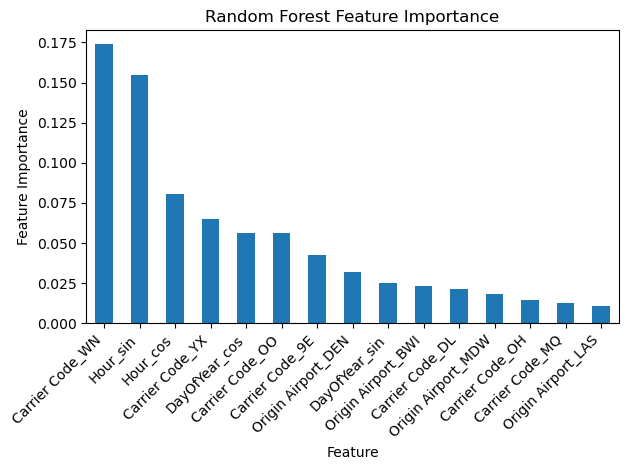

In [38]:
import matplotlib.pyplot as plt

feature_importances_series.index = feature_importances_series.index.str.split('__').str[-1]
ax = feature_importances_series.head(15).plot.bar(rot=45)
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
ax.set_title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('../../../Downloads/All_Airports_Random_Forest_Feature_Importance.png')

In [39]:
print(f'Number of unique tail numbers: {X_train['Tail Number'].nunique()}')
print(f'Number of unique destination airports: {X_train['Destination Airport'].nunique()}')

Number of unique tail numbers: 6682
Number of unique destination airports: 353


In [17]:
X_train = train.drop(['Delayed', 'Date (MM/DD/YYYY)', 'Tail Number', 'Destination Airport'], axis=1)
y_train = train['Delayed']
X_test = test.drop(['Delayed', 'Date (MM/DD/YYYY)', 'Tail Number', 'Destination Airport'], axis=1)
y_test = test['Delayed']

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import TruncatedSVD

cat_cols = ['Origin Airport', 'Carrier Code']
date_cols = ['DayOfYear']
time_cols = ['Hour']
feature_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('day_sin', SinTransformer(365), date_cols),
        ('day_cos', CosTransformer(365), date_cols),
        ('hour_sin', SinTransformer(24), time_cols),
        ('hour_cos', CosTransformer(24), time_cols),
    ]
)

rnd_forest_pipeline_reduced = Pipeline([
        ('data_transformer', feature_transformer),
        ('rnd_forest_clf', RandomForestClassifier(criterion='gini', 
                                                  n_jobs=-1,
                                                  n_estimators=300,
                                                  max_depth=25, 
                                                  min_samples_split=31, 
                                                  min_samples_leaf=42,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=179,
                                                  class_weight='balanced'))
    ])

rnd_forest_pipeline_reduced.fit(X_train, y_train.values.ravel())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('data_transformer', ...), ('rnd_forest_clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('encoder', ...), ('day_sin', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the

In [19]:
forest_reduced_pred = rnd_forest_pipeline_reduced.predict(X_test)
forest_reduced_results = {'Accuracy': accuracy_score(y_test, forest_reduced_pred),
               'Precision': precision_score(y_test, forest_reduced_pred),
               'Recall': recall_score(y_test, forest_reduced_pred),
               'F1': f1_score(y_test, forest_reduced_pred)}
print(forest_reduced_results)
print("\nFinal Classification Report:")
print(classification_report(y_test, forest_reduced_pred, zero_division=0))

{'Accuracy': 0.6310371405062406, 'Precision': 0.5111823243393041, 'Recall': 0.5630818038722912, 'F1': 0.5358783891924042}

Final Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.69   2961189
           1       0.51      0.56      0.54   1801724

    accuracy                           0.63   4762913
   macro avg       0.61      0.62      0.61   4762913
weighted avg       0.64      0.63      0.63   4762913



In [21]:
feature_names_reduced = rnd_forest_pipeline_reduced.named_steps['data_transformer'].get_feature_names_out(input_features=X_train.columns)
rnd_forest_reduced_importances = rnd_forest_pipeline_reduced.named_steps['rnd_forest_clf'].feature_importances_
feature_importances_series_reduced = pd.Series(rnd_forest_reduced_importances, index=feature_names_reduced).sort_values(ascending=False)

print(feature_importances_series_reduced[:15])

hour_sin__Hour_sin             0.274297
encoder__Carrier Code_WN       0.255769
day_cos__DayOfYear_cos         0.079353
hour_cos__Hour_cos             0.077624
encoder__Carrier Code_YX       0.058618
encoder__Carrier Code_OO       0.046669
encoder__Carrier Code_9E       0.034507
day_sin__DayOfYear_sin         0.023047
encoder__Origin Airport_DEN    0.016163
encoder__Carrier Code_B6       0.012827
encoder__Carrier Code_DL       0.012067
encoder__Carrier Code_AA       0.011156
encoder__Carrier Code_MQ       0.010987
encoder__Carrier Code_OH       0.009694
encoder__Origin Airport_BWI    0.008656
dtype: float64
